In [5]:
import msprime
import tskit
import random
import numpy as np
import random
import sklearn

import pandas as pd
from numpy import linalg as LNG 
from random import randint, randrange


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 


import seaborn
import matplotlib
from matplotlib import pyplot as plt

import math
import scipy
import scipy.optimize as optimize
from scipy.optimize import minimize


C:\Users\777\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [1]:
# --- Demographic model ---

def history_archaic(gen_time, len_seq, rr,mu, n_e, t,  n, rand_sd, n_neand, t_neand_samples, n_eu ):
    
        
    n_ANC, n_ND, n_AMH, n_OOF,n_AF, n_EU = n_e
    t_NEAND_migration, t_NEAND_AMH, t_OOF_AF = t
    
    demography = msprime.Demography()
    
    
    demography.add_population(name="AF", initial_size=n_AF)
    demography.add_population(name="EU", initial_size=n_EU)
    demography.add_population(name="AMH", initial_size=n_AMH)
    demography.add_population(name="NEAND", initial_size=n_ND)
    demography.add_population(name="ANCES", initial_size=n_ANC)  #common population for Neanderthal and AMH 

    demography.add_mass_migration(time=t_NEAND_migration, source='EU', dest='NEAND', proportion=0.05)
    demography.add_population_split(time = t_OOF_AF, derived=["AF", "EU"], ancestral="AMH")
    demography.add_population_split(time = t_NEAND_AMH, derived=["AMH", "NEAND"], ancestral="ANCES")


    ts = msprime.sim_ancestry(
        samples=        [       
                msprime.SampleSet(n_eu, ploidy=1, population='EU'), 
                msprime.SampleSet(n, ploidy=1, population='AF'),
                msprime.SampleSet(n_neand, ploidy=1, population='NEAND', time = t_neand_samples)          
               
        ],
    
        ploidy=1,    
        sequence_length=len_seq,
        recombination_rate=rr, 
        demography=demography,
        record_migrations=True, 
        random_seed=1234,
        
                                
    )
   
    
    ts = msprime.sim_mutations(ts, rate=mu, random_seed=rand_sd)    
    return ts

In [2]:
#несколько вспомогательных функций
def connected(m):
    for i in range(len(m)-1):
        if m[i][1] == m[i+1][0]:
            return True
    return False
        
def remove_one(m):
    mas = m
    while connected(mas) == True:
        for i in range(len(mas)-1):
            if mas[i][1] == mas[i+1][0]:
                mas[i][1] = mas[i+1][1]
                mas.pop(i+1)
                break
    return mas


#Вход: ts, название популяции, индивид(которого мы препарируем), время предка
def get_migrating_tracts_ind(ts, pop_name, ind, T_anc):
    
    pop=-1
    for i in ts.populations():
        if i.metadata['name']==pop_name:
            pop=i.id
    
    mig = ts.tables.migrations
    migration_int = []

    for tree in ts.trees():  #перебираем все деревья. Как известно, каждому дереву отвечает участок днк  
        anc_node = ind #chose observable node
        while tree.time( tree.parent(anc_node) ) <= T_anc : #идем в прошлое до вершины anc_node по предкам нашего мексиканца, пока не наткнемся на миграцию 
            anc_node = tree.parent(anc_node)
        migs = np.where(mig.node == anc_node)[0] #выбирем все строки, соответствующие заданному узлу

        #идем по таблице миграций с anc_node и проверяем, чтобы миграции попадали в тот самый участок днк
        for i in migs:

            stroka = mig[i]
            if stroka.time == T_anc and stroka.dest == pop and tree.interval.left >= stroka.left and tree.interval.right <= stroka.right:
                migration_int.append([tree.interval.left, tree.interval.right])

    migration_int2 = []
    for i in range(len(migration_int)):
        if migration_int[i][0] != migration_int[i][1]:
            migration_int2.append(migration_int[i])
    migration_int = migration_int2
    
    mi = remove_one(migration_int)
    mi.sort()  

    return mi 

def tracts_eu(tr_nd):
    result = []
    if tr_nd[0][0] > 0:
        result.append([0,tr_nd[0][0]-1])
        
    for i in range(len(tr_nd)-1):
        result.append([tr_nd[i][1], tr_nd[i+1][0]])
      
    return result            

In [3]:
#функция, наблюдения; #n_neanderthal is the number of neanderthal samples in observations
def createSeqObs_main(ts,cut,pop, ind, n, n_ref_pop, n_neanderthal ):     
    
    inx = []
    if pop == 'NEAND':
        inx=[i for i in range(n+n_eu, n+n_eu+n_neanderthal)]

    if pop == 'AF':
        inx = [i for i in range(n_eu, n_eu+n_ref_pop)]        

    seq = np.zeros(int(ts.sequence_length/cut),dtype=int)    
    for v in ts.variants():
        i=int(v.site.position/cut)
        
        flag = False
        for j in inx:
            if abs(v.genotypes[j]-v.genotypes[ind])==0:
                flag = True
                break
                
            
        if flag == False:
            seq[i] += 1
              
    return seq

In [38]:
#Ti: Introgression of Nd
def initA(Ti,cut,a) -> np.array:
    A = np.zeros((2,2))
    
    A[0][1]=Ti*RR*cut*a
    A[0][0]=1-A[0][1]
 
    A[1][0]=Ti*RR*cut*(1-a)
    A[1][1]=1-A[1][0]
    
    return A

#Ti: Introgression of Nd
#Taf: Time out of Africa
#Tn: Time of Split between Nd and Sapiens

def initB(m,cut, lmbd, n_st) -> np.array: 
    
    B = np.empty(shape=(2,n_st,n_st))
    meani = lmbd[0]
    meann = lmbd[1]
    meanaf = lmbd[2]
    
    Pi = np.empty(n_st)
    Paf=np.empty(n_st)
    Pn=np.empty(n_st)

    
    Pi[0]=np.exp(-meani)
    Paf[0]=np.exp(-meanaf)
    Pn[0]=np.exp(-meann)
    
    sumi=0
    sumaf=0
    sumn=0
    
    for i in range(1,n_st):
        Pi[i]=Pi[i-1]*meani/i
        Paf[i]=Paf[i-1]*meanaf/i
        Pn[i]=Pn[i-1]*meann/i
        
        sumi=sumi+Pi[i]
        sumaf=sumaf+Paf[i]
        sumn=sumn+Pn[i]

    Pi[0]=1-sumi
    Paf[0]=1-sumaf
    Pn[0]=1-sumn
    
    for i in range(n_st): 
        for j in range(n_st):
            B[0][i][j]=Paf[i]*Pn[j]
            B[1][i][j]=Pn[i]*Pi[j]
                  
    return B


#Ti: Introgression of Nd
#Taf: Time out of Africa
#Tn: Time of Split between Nd and Sapiens

def initBwN(m,cut, lmbd, n_st) -> np.array: 
    
    B = np.empty(shape=(2,n_st))
    meann = lmbd[1]
    meanaf = lmbd[2]


    Paf=np.empty(n_st)
    Pn=np.empty(n_st)

    Paf[0]=np.exp(-meanaf)
    Pn[0]=np.exp(-meann)
    

    sumaf=0
    sumn=0
    
    for i in range(1,n_st):
        Paf[i]=Paf[i-1]*meanaf/i
        Pn[i]=Pn[i-1]*meann/i
        
        sumaf=sumaf+Paf[i]
        sumn=sumn+Pn[i]

    Paf[0]=1-sumaf
    Pn[0]=1-sumn
    
    for i in range(n_st): 
        B[0][i]=Paf[i]
        B[1][i]=Pn[i]
               

    return B

In [29]:

# forward-algo
def alpha_scaled_opt(a,b, o, p, cut):
    
    c = np.zeros(int(seq_length/cut)) #scaling factors, которые как раз позволяют не обнулиться
    
    alpha = np.zeros((N, int(seq_length/cut)))
    alpha[:, 0] = b[:, o[0][0],o[0][1]] * p
    
    c[0] = 1 / sum(alpha[:, 0])
    alpha[:, 0] = alpha[:, 0] / sum(alpha[:, 0])
    
    
    

    for t in range(1, int(seq_length/cut)):   
        
        for i in range(0, N):
            alpha[i, t] = np.dot(alpha[:, t-1],a[:,i]) * b[i, o[t][0],o[t][1]] 
            
        c[t] = 1 / sum(alpha[:,t]) #сохраняем множители        
        alpha[:, t] = alpha[:, t] / sum(alpha[:,t])     
        
    return alpha, c

# Backward procedure. Scaled case.
def beta_scaled_opt(a,b, o, scaling_factors, cut):
    
    beta = np.zeros((N, int(seq_length/cut)))
    
    length = int(seq_length/cut)
    beta[:, length - 1] = np.ones(N)*scaling_factors[length-1] 
    

    for t in range(int(seq_length/cut)-2,-1,-1):             
        for i in range(0, N):             
            for l in range(0, N):
                beta[i, t] += a[i, l] * b[l, o[t+1][0],o[t+1][1]] * beta[l, t+1]
                
        beta[:, t] = beta[:, t] * scaling_factors[t]

    return beta 

# gamma matrix
def def_gamma(alpha, beta):
        
    gamma = np.zeros((N,len(alpha[0])))
    for m in range(0, len(alpha[0])):
        denom = sum(alpha[:, m]*beta[:,m])
        
        for i in range(0,N):
            gamma[i, m] = (alpha[i, m] * beta[i, m]) / denom
    return gamma


# ksi[i, j, t]
def def_ksi( a, b, o, alpha, beta):
    
    M = len(o)
    ksi = np.zeros((N, N, M-1))
    
    for t in range(0, M-1):
        
        denom = 0
        for i in range(0, N):
            for j in range(0, N):
                denom += alpha[i, t] * a[i, j] * b[j, o[t+1][0],o[t+1][1]] * beta[j, t+1]
                
        
        for i in range(0, N):
            for j in range(0, N):
                ksi[i, j, t] = (alpha[i, t]*a[i, j]*b[j, o[t+1][0],o[t+1][1]] * beta[j, t+1]) / denom
    
    return ksi

In [30]:

# forward-algo
def alpha_scaled_opt_wN(a,b, o, p, cut):
    
    c = np.zeros(int(seq_length/cut)) #scaling factors, которые как раз позволяют не обнулиться
    
    alpha = np.zeros((N, int(seq_length/cut)))
    alpha[:, 0] = b[:, o[0]] * p
    
    c[0] = 1 / sum(alpha[:, 0])
    alpha[:, 0] = alpha[:, 0] / sum(alpha[:, 0])
    
    
    

    for t in range(1, int(seq_length/cut)):   
        
        for i in range(0, N):
            alpha[i, t] = np.dot(alpha[:, t-1],a[:,i]) * b[i, o[t]] 
            
        c[t] = 1 / sum(alpha[:,t]) #сохраняем множители        
        alpha[:, t] = alpha[:, t] / sum(alpha[:,t])     
        
    return alpha, c

# Backward procedure. Scaled case.
def beta_scaled_opt_wN(a,b, o, scaling_factors, cut):
    
    beta = np.zeros((N, int(seq_length/cut)))
    
    length = int(seq_length/cut)
    beta[:, length - 1] = np.ones(N)*scaling_factors[length-1] 
    

    for t in range(int(seq_length/cut)-2,-1,-1):             
        for i in range(0, N):             
            for l in range(0, N):
                beta[i, t] += a[i, l] * b[l, o[t+1]] * beta[l, t+1]
                
        beta[:, t] = beta[:, t] * scaling_factors[t]

    return beta 

# gamma matrix
def def_gamma_wN(alpha, beta):
        
    gamma = np.zeros((N,len(alpha[0])))
    for m in range(0, len(alpha[0])):
        denom = sum(alpha[:, m]*beta[:,m])
        
        for i in range(0,N):
            gamma[i, m] = (alpha[i, m] * beta[i, m]) / denom
    return gamma


# ksi[i, j, t]
def def_ksi_wN( a, b, o, alpha, beta):
    
    M = len(o)
    ksi = np.zeros((N, N, M-1))
    
    for t in range(0, M-1):
        
        denom = 0
        for i in range(0, N):
            for j in range(0, N):
                denom += alpha[i, t] * a[i, j] * b[j, o[t+1]] * beta[j, t+1]
                
        
        for i in range(0, N):
            for j in range(0, N):
                ksi[i, j, t] = (alpha[i, t]*a[i, j]*b[j, o[t+1]] * beta[j, t+1]) / denom
    
    return ksi

In [9]:
def viterbi(V, initial_distribution, a, b):
    
    T = len(V)
    M = a.shape[0]
 
    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0][0],V[0][1]])
 
    prev = np.zeros((T - 1, M))
 
    for t in range(1, T):
        for j in range(M):
            # Same as Forward Probability
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t][0], V[t][1]])
 
            # This is our most probable state given previous state at time t (1)
            prev[t - 1, j] = np.argmax(probability)
 
            # This is the probability of the most probable state (2)
            omega[t, j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    S = np.flip(S, axis=0)
 
    # Convert numeric values to actual hidden states
 
    result = []
    for s in S:
        if s == 0:
            result.append(0)
        elif s == 1:
            result.append(1)

    return result

def viterbinD(V, initial_distribution, a, b):
    
    T = len(V)
    M = a.shape[0]
 
    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0]])
 
    prev = np.zeros((T - 1, M))
 
    for t in range(1, T):
        for j in range(M):
            # Same as Forward Probability
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
 
            # This is our most probable state given previous state at time t (1)
            prev[t - 1, j] = np.argmax(probability)
 
            # This is the probability of the most probable state (2)
            omega[t, j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    S = np.flip(S, axis=0)
 
    # Convert numeric values to actual hidden states
 
    result = []
    for s in S:
        if s == 0:
            result.append(0)
        elif s == 1:
            result.append(1)

    return result


def get_HMM_tracts(seq):
    migrating_tracts = []
    for i in range(N):
        migrating_tracts.append([])
    start=0
    for i in range(1,len(seq)):
        if seq[i]!=seq[i-1]:
            migrating_tracts[seq[i-1]].append([start,i-1])
            start=i
    migrating_tracts[seq[len(seq)-1]].append([start,len(seq)-1])
    return migrating_tracts

In [10]:
#something for classification report

def intersections(a,b):
    ranges = []
    i = j = 0
    while i < len(a) and j < len(b):
        a_left, a_right = a[i]
        b_left, b_right = b[j]

        if a_right < b_right:
            i += 1
        else:
            j += 1

        if a_right >= b_left and b_right >= a_left:
            end_pts = sorted([a_left, a_right, b_left, b_right])
            middle = [end_pts[1], end_pts[2]]
            ranges.append(middle)

    ri = 0
    while ri < len(ranges)-1:
        if ranges[ri][1] == ranges[ri+1][0]:
            ranges[ri:ri+2] = [[ranges[ri][0], ranges[ri+1][1]]]

        ri += 1

    return ranges



def ne_set_interval(set_intervals):
    
    ne_set = []
    for j in range(len(set_intervals)):
        
        if j==0:
            ne_set.append([0,set_intervals[j][0]-1])
        if j== len(set_intervals)-1:
            ne_set.append([set_intervals[j][1]+1, seq_length-1])
        if j!=0 and j!= len(set_intervals)-1:
            ne_set.append([set_intervals[j-1][1]+1, set_intervals[j][0]-1])
    return ne_set

def len_tracts(set_intervals):
    if len(set_intervals)==0:
        return 0
    else:
        s=0
        for j in range(len(set_intervals)):
            s+= set_intervals[j][1]-set_intervals[j][0]+1
        return s
    
def confusion_mtrx(real, res_HMM):
    conf_matrix = np.zeros((2,2))
    for i in range(N):
        for j in range(N):
            conf_matrix[i,j] =int(len_tracts(intersections(real[i], res_HMM[j])))
    return conf_matrix

def classification_rpt(conf_matrix):
    clas_report = {}
    for i in range(N):
        dd={}
        dd['precision'] = round(conf_matrix[i,i]/sum(conf_matrix[:,i]),5)
        dd['recall'] = round(conf_matrix[i,i]/sum(conf_matrix[i,:]),5)
        dd['f1-score'] = round(2*dd['recall']*dd['precision']/(dd['recall']+dd['precision']), 5)
        clas_report[str(i)] = dd
    return clas_report



In [39]:
# "flag" is about using or non-using neanderthal reference genomes
def createSeqObs_several(ts, cut,  n, n_ref_pop, n_neanderthal,  n_obs_seq ):
    if n_neanderthal != 0:
        seq=[]    
        number_states = 0
        for idx in range(0, n_obs_seq):
            ind = idx
            seqAf=createSeqObs_main(ts, cut,'AF', ind, n, n_ref_pop, n_neanderthal ) 
            seqND=createSeqObs_main(ts, cut,'NEAND', ind, n, n_ref_pop, n_neanderthal )
            seq.append(np.column_stack((seqAf,seqND)))

            if number_states < max([max(seqAf), max(seqND)]) :
                number_states = max([max(seqAf), max(seqND)])
                
    else:
        seq=[]    
        number_states = 0   

        for idx in range(0, n_obs_seq):
            ind = idx
            seqAf=createSeqObs_main(ts, cut, 'AF', ind, n, n_ref_pop, n_neanderthal ) 
            seq.append(seqAf)

            if number_states < max(seqAf) :
                number_states = max(seqAf)
                
    return np.array(seq), number_states+1
    

In [42]:
def opt_params(seq, n_st, lmbd_00, epsilon, n_neanderthals, bnds, ind_num, cut, n_step):
    lmbd_0 = lmbd_00
    if n_neanderthals != 0:
        for iii in range(n_step):
        
            A_0 = initA(cut, lmbd_0[0]/d, 0.05)
            b_0 = initB(MU, cut, lmbd_0[0:3], n_st+1)
            P=[0.95, 0.05]
        
            alpha, sc_factors = alpha_scaled_opt(A_0,b_0, seq [ind_num], P, cut)
            beta = beta_scaled_opt(A_0, b_0, seq [ind_num], sc_factors, cut)        
            gamma = def_gamma(alpha, beta)
            ks = def_ksi( A_0, b_0, seq [ind_num], alpha, beta)
            coeff_a = np.zeros((N, N))

            for i in range(N):
                for j in range(N):                
                    for t in range(int(seq_length/cut)-1):
                        coeff_a[i, j] += ks[i, j, t] 

            def multi_Q(lmbd):

                lmbd=np.array(lmbd)
                Q=0
                A = initA(cut,lmbd[0]/d, 0.05)
                b = initB(MU, cut, lmbd[0:3],  n_st+1)


                for ii in range(N):
                    for jj in range(N):
                        Q += math.log(A[ii,jj]) * coeff_a[ii,jj]

                for ii in range(N):
                    for t in range(int(seq_length/cut)):
                        Q += math.log ( b[ii, seq [ind_num][t][0], seq [ind_num][t][1]]) * gamma[ii,t]

                return -Q

            def gradient_respecting_bounds(bounds, fun, eps=epsilon):
                """bounds: list of tuples (lower, upper)"""
                def gradient(x):
                    fx = fun(x)
                    grad = np.zeros(len(x))
                    for k in range(len(x)):
                        d = np.zeros(len(x))
                        d[k] = eps if x[k] + eps <= bounds[k][1] else -eps
                        grad[k] = (fun(x + d) - fx) / d[k]
                    return grad
                return gradient

            opt_result = scipy.optimize.minimize(multi_Q, 
                                                 lmbd_0,                                                 
                                                 bounds=bnds,                                                  
                                                 method="L-BFGS-B" )


            if LNG.norm(lmbd_0-opt_result.x) < epsilon:
                break
            else:
                lmbd_0[0:3] = opt_result.x[0:3]   
    else:
        for iii in range(n_step):
            A_0 = initA(cut,lmbd_0[0]/d, 0.05)
            b_0 = initBwN(MU, cut, lmbd_0[0:3],  n_st+1)
            P=[0.95, 0.05]


            alpha, sc_factors = alpha_scaled_opt_wN(A_0,b_0, seq[ind_num], P, cut)
            beta = beta_scaled_opt_wN(A_0, b_0, seq [ind_num], sc_factors, cut)        
            gamma = def_gamma_wN(alpha, beta)
            ks = def_ksi_wN( A_0, b_0, seq [ind_num], alpha, beta)
            coeff_a = np.zeros((N, N))

            for i in range(N):
                for j in range(N):                
                    for t in range(int(seq_length/cut)-1):
                        coeff_a[i, j] += ks[i, j, t] 

            def multi_Q(lmbd):
                lmbd=np.array(lmbd)
                Q=0
                A = initA(cut,lmbd[0]/d, 0.05)
                b = initBwN(MU, cut, lmbd[0:3],  n_st+1)


                for ii in range(N):
                    for jj in range(N):
                        Q += math.log(A[ii,jj]) * coeff_a[ii,jj]

                for ii in range(N):
                    for t in range(int(seq_length/cut)):
                        Q += math.log ( b[ii, seq [ind_num][t]]) * gamma[ii,t]


                return -Q

            def gradient_respecting_bounds(bounds, fun, eps=epsilon):
                """bounds: list of tuples (lower, upper)"""
                def gradient(x):
                    fx = fun(x)
                    grad = np.zeros(len(x))
                    for k in range(len(x)):
                        d = np.zeros(len(x))
                        d[k] = eps if x[k] + eps <= bounds[k][1] else -eps
                        grad[k] = (fun(x + d) - fx) / d[k]
                    return grad
                return gradient

            opt_result = scipy.optimize.minimize(multi_Q,
                                                 lmbd_0,                                                 
                                                 bounds=bnds,                                                  
                                                 method="L-BFGS-B" )

            if LNG.norm(lmbd_0-opt_result.x) < epsilon:
                break
            else:
                lmbd_0[0:3] = opt_result.x[0:3]
    return opt_result.x     

In [115]:
def createDataFrame(cut,lmbd_opt, n_st, seq, n_neanderthal,  n_ref_pop, n_obs_seq, nd_true_tracts):
    df= pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'n_eu',
                                       'n_neand', 'L',  'n_ref_pop','n_e_nd'])
    

    if n_neanderthal != 0:
        d = 2 * MU * cut


        A = initA(cut,lmbd_opt[0]/d, 0.05)
        B = initB(MU, cut, lmbd_opt[0:3],   n_st+1)
        P=[0.95, 0.05]

        for idx in range(0, n_obs_seq):
            tracts_HMM =  get_HMM_tracts(viterbi(seq [idx], P, A, B))
            for k in range(N):
                for j in range(len(tracts_HMM[k])):
                    tracts_HMM[k][j][0]= cut * tracts_HMM[k][j][0]
                    tracts_HMM[k][j][1]= cut * tracts_HMM[k][j][1]

            real_tracts_in_states = []           
            real_tracts_in_states.append(tracts_eu(nd_true_tracts[idx]))
            real_tracts_in_states.append(nd_true_tracts[idx])
            cl_report = classification_rpt(confusion_mtrx(real_tracts_in_states, tracts_HMM))
            
            for j in range(N):
                df.loc[len(df.index)] = [j, cl_report[str(j)]['precision'], 'precision',idx, n_neanderthal, cut,n_ref_pop,  N_ND]
                df.loc[len(df.index)] = [j, cl_report[str(j)]['recall'], 'recall',idx, n_neanderthal, cut, n_ref_pop,  N_ND]
                df.loc[len(df.index)] = [j, cl_report[str(j)]['f1-score'], 'f1-score',idx, n_neanderthal, cut,n_ref_pop, N_ND]
    else:
        d = 2 * MU * cut


        A = initA(cut,lmbd_opt[0]/d, 0.05)
        B = initBwN(MU, cut, lmbd_opt[0:3],   n_st+1)
        P=[0.95, 0.05]

        for idx in range(0, n_obs_seq):
            tracts_HMM =  get_HMM_tracts(viterbinD(seq [idx], P, A, B))
            for k in range(N):
                for j in range(len(tracts_HMM[k])):
                    tracts_HMM[k][j][0]= cut * tracts_HMM[k][j][0]
                    tracts_HMM[k][j][1]= cut * tracts_HMM[k][j][1]

            real_tracts_in_states = []
            real_tracts_in_states.append(tracts_eu(nd_true_tracts[idx]))
            real_tracts_in_states.append(nd_true_tracts[idx])
            cl_report = classification_rpt(confusion_mtrx(real_tracts_in_states, tracts_HMM))
            

            for j in range(N):
                df.loc[len(df.index)] = [j, cl_report[str(j)]['precision'], 'precision',idx, n_neanderthal, cut,n_ref_pop, N_ND]
                df.loc[len(df.index)] = [j, cl_report[str(j)]['recall'], 'recall',idx, n_neanderthal, cut, n_ref_pop, N_ND]
                df.loc[len(df.index)] = [j, cl_report[str(j)]['f1-score'], 'f1-score',idx, n_neanderthal, cut,n_ref_pop,  N_ND]


    return df


In [15]:
# Generation time, mutation rate and recomination rate
RR = 1e-8
MU = 1.25e-8 
GEN_time = 25.0 

# Split Times
T_NEAND_migration = 50000 #time of Neanderthal migration into Out_of_africa population
T_NEAND_AMH = 650000 # split time between AMH and Neanderthal
T_OOF_AF = 72000 # Out_of_Africa migration time
T_NEAND_samples = 38000

# Effective population size
N_ANC = 7310 # N_e of common  AMH and NEanderthal population 
N_ND = 3000 # N_e of Neanderthal
N_AMH = 14474 # N_e of AMH
N_OOF = 1861 # N_e of Out_of_Africa population
N_AF = 30000 # N_e of Africans
N_EU = 34039 #N_e of Europeans
N_ND = 3000

gr_admix = 0.05

len_sequence = 2e7 # DNA sequence length
seq_length = len_sequence
n = 250 # number of generated  NA, EU, AF samples
n_neand = 20 #number of generated Neanderthals

rand_sd =4398 #random seed

T = np.array([T_NEAND_migration, T_NEAND_AMH, T_OOF_AF])/GEN_time
N_e = np.array([N_ANC, N_ND, N_AMH, N_OOF, N_AF, N_EU])

n_eu=40

In [16]:
ts =history_archaic(GEN_time, len_sequence, RR, MU, N_e, T,  n, rand_sd, n_neand,  T_NEAND_samples/GEN_time, n_eu)


In [109]:
N_obs = n_eu
ND_true_tracts = []
for idx in range(0, N_obs):       
    ND_true_tracts.append( get_migrating_tracts_ind(ts, 'NEAND', idx, T[0]))
    

# L-dependency

In [113]:
L_mas = [250, 500, 1000, 2000]
N_ref_pop = 100
N_neanderthal = 4

N_obs = n_eu

SEQ = []
SEQ_noND = []
N_st_noND = []
N_st = []

N=2

for i_L in range(len(L_mas)):
    sq, num = createSeqObs_several(ts, L_mas[i_L],  n, N_ref_pop, N_neanderthal,  N_obs )
    SEQ.append(sq)
    N_st.append(num)
    print(i_L)
    
for i_L in range(len(L_mas)):
    sq, num = createSeqObs_several(ts, L_mas[i_L],  n, N_ref_pop, 0,  N_obs )
    SEQ_noND.append(sq)
    N_st_noND.append(num)

0
1
2
3


In [114]:
opt_params_values = []
opt_params_values_noND = []
n_EM_steps = 10
epsilon = 1e-16
for i_L in range(len(L_mas)):
    
    d = 2 * L_mas[i_L] * MU
    bnds = ((d*T[0], d*(T[0]+10000/GEN_time)), (d*T[1], d*(T[1]+100000/GEN_time)), 
             (d*T[2], d*(T[2]+50000/GEN_time)))

    lmbd_00 = np.zeros(3)
    lmbd_00[0:3]= d * np.array([T[0]+400, T[1]+4000, T[2]+300])
    ind_num = 0
    
    opt_params_values .append(opt_params(SEQ[i_L], N_st[i_L], lmbd_00, epsilon, N_neanderthal, bnds, ind_num, L_mas[i_L], n_EM_steps))
    opt_params_values_noND .append(opt_params(SEQ_noND[i_L], N_st_noND[i_L], lmbd_00, epsilon, 0, bnds, ind_num, L_mas[i_L], n_EM_steps))

In [117]:
DF_L= pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'n_eu',
                                       'n_neand', 'L',  'n_ref_pop','n_e_nd'])

for i_L in range(len(L_mas)):
    DF_L=pd.concat([createDataFrame(L_mas[i_L], opt_params_values[i_L], N_st[i_L], SEQ[i_L], N_neanderthal, 
                                    N_ref_pop, N_obs, ND_true_tracts), DF_L], ignore_index=True) 

    DF_L=pd.concat([createDataFrame(L_mas[i_L], opt_params_values_noND[i_L], N_st_noND[i_L], SEQ_noND[i_L], 0,
                                    N_ref_pop, N_obs, ND_true_tracts), DF_L], ignore_index=True)   
DF_L.to_csv('L.dependency.csv', encoding='utf-8',index=False) 

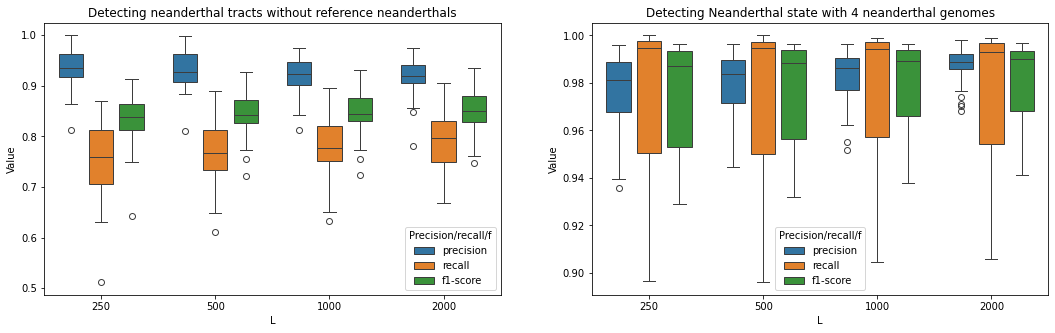

In [119]:
DF_L_1 = DF_L[DF_L['State']==1& (DF_L['n_neand']==N_neanderthal)] 
DF_L_noND_1 = DF_L[(DF_L['State']==1) & (DF_L['n_neand']==0)] 


fig, axes = plt.subplots(1, 2, figsize=(18, 5))

seaborn.boxplot(ax=axes[0],data=DF_L_noND_1, x="L", y="Value", hue="Precision/recall/f", gap=.2).set_title('Detecting neanderthal tracts without reference neanderthals')
seaborn.boxplot(ax=axes[1],data=DF_L_1, x="L", y="Value", hue='Precision/recall/f', gap=.2).set_title('Detecting Neanderthal state with 4 neanderthal genomes')

plt.savefig('L.dep.png')

# Neanderthal dependency

In [120]:
L=1000
N_ref_pop = 100
N_neanderthal_mas = [0,2,4,6,8]

SEQ_nd = []
N_st_nd = []

N=2

for i_N_neanderthal in range(len(N_neanderthal_mas)):
    N_neanderthal = N_neanderthal_mas[i_N_neanderthal]
    sq, num = createSeqObs_several(ts, L,  n, N_ref_pop, N_neanderthal,  N_obs )
    SEQ_nd.append(sq)
    N_st_nd.append(num)

In [121]:
opt_params_values_nd = []
n_EM_steps = 10
epsilon = 1e-16


for i_N_neanderthal in range(len(N_neanderthal_mas)):
    N_neanderthal = N_neanderthal_mas[i_N_neanderthal]
    
    d = 2 * L * MU
    bnds = ((d*T[0], d*(T[0]+10000/GEN_time)), (d*T[1], d*(T[1]+100000/GEN_time)), 
             (d*T[2], d*(T[2]+50000/GEN_time)))

    lmbd_00 = np.zeros(3)
    lmbd_00[0:3]= d * np.array([T[0]+400, T[1]+4000, T[2]+300])
    ind_num = 0
    
    opt_params_values_nd .append(opt_params(SEQ_nd[i_N_neanderthal], N_st_nd[i_N_neanderthal], lmbd_00, epsilon, N_neanderthal, bnds, ind_num, L, n_EM_steps))
 

In [122]:
DF_nd= pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'n_eu',
                                       'n_neand', 'L',  'n_ref_pop','n_e_nd'])

for i_N_neanderthal in range(len(N_neanderthal_mas)):
    N_neanderthal = N_neanderthal_mas[i_N_neanderthal]
    DF_nd=pd.concat([createDataFrame(L, opt_params_values_nd[i_N_neanderthal], N_st_nd[i_N_neanderthal], SEQ_nd[i_N_neanderthal], N_neanderthal,
                                     N_ref_pop, N_obs, ND_true_tracts), DF_nd], ignore_index=True)      
DF_nd.to_csv('nd.dependency.csv', encoding='utf-8',index=False) 

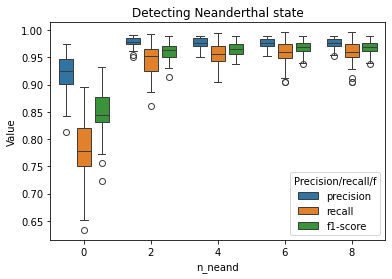

In [124]:


DF_nd_1 = DF_nd[DF_nd['State']==1] 

#fig, axes = plt.subplots(1, 1, figsize=(5, 5))


seaborn.boxplot(data=DF_nd_1, x="n_neand", y="Value", hue='Precision/recall/f', gap=.2).set_title('Detecting Neanderthal state')

plt.savefig('ND.dep.png')

# number of outgroup samples dependency

In [127]:
L=1000
N_ref_pop_mas = [1,5, 10, 25, 50, 100, 200]
N_neanderthal = 4

SEQ_ref_pop = []
N_st_ref_pop = []
SEQ_ref_pop_noND = []
N_st_ref_pop_noND = []


N=2

for i_N_ref_pop in range(len(N_ref_pop_mas)):
    print(i_N_ref_pop)
    N_ref_pop = N_ref_pop_mas[i_N_ref_pop]

    sq, num = createSeqObs_several(ts, L,  n, N_ref_pop, N_neanderthal,  N_obs )
    SEQ_ref_pop.append(sq)
    N_st_ref_pop.append(num)
    
    sq, num = createSeqObs_several(ts, L,  n, N_ref_pop, 0,  N_obs )
    SEQ_ref_pop_noND.append(sq)
    N_st_ref_pop_noND.append(num)

0
1
2
3
4
5
6


In [137]:
opt_params_values_ref_pop = []
opt_params_values_ref_pop_noND = []
n_EM_steps = 10
epsilon = 1e-16
for i_N_ref_pop in range(len(N_ref_pop_mas)):
    N_ref_pop = N_ref_pop_mas[i_N_ref_pop]
    d = 2 * L * MU
    bnds = ((d*T[0], d*(T[0]+10000/GEN_time)), (d*T[1], d*(T[1]+100000/GEN_time)), 
             (d*T[2], d*(T[2]+50000/GEN_time)))

    lmbd_00 = np.zeros(3)
    lmbd_00[0:3]= d * np.array([T[0]+400, T[1]+4000, T[2]+300])
    ind_num = 0
    
    opt_params_values_ref_pop.append(opt_params(SEQ_ref_pop [i_N_ref_pop ], N_st_ref_pop [i_N_ref_pop ],
                                                lmbd_00, epsilon, N_neanderthal, bnds, ind_num, L, n_EM_steps))
    opt_params_values_ref_pop_noND.append(opt_params(SEQ_ref_pop_noND[i_N_ref_pop ],
                                                                  N_st_ref_pop_noND[i_N_ref_pop ], lmbd_00, 
                                                                  epsilon, 0, bnds, ind_num, L, n_EM_steps))

In [138]:
opt_params_values_ref_pop_noND

[array([0.06 , 0.65 , 0.122]),
 array([0.06     , 0.65     , 0.0986027]),
 array([0.06      , 0.65      , 0.07524642]),
 array([0.06 , 0.65 , 0.072]),
 array([0.05693347, 0.65      , 0.072     ]),
 array([0.05 , 0.65 , 0.072]),
 array([0.05 , 0.65 , 0.072])]

In [144]:
DF_ref_pop = pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'n_eu',
                                       'n_neand', 'L',  'n_ref_pop','n_e_nd'])
for i_N_ref_pop in range(len(N_ref_pop_mas)):
    N_ref_pop = N_ref_pop_mas[i_N_ref_pop]
    DF_ref_pop=pd.concat([createDataFrame(L, opt_params_values_ref_pop[i_N_ref_pop], N_st_ref_pop[i_N_ref_pop ], 
                                    SEQ_ref_pop[i_N_ref_pop ], N_neanderthal, 
                                    N_ref_pop, N_obs, ND_true_tracts), DF_ref_pop], ignore_index=True) 

    DF_ref_pop=pd.concat([createDataFrame(L, opt_params_values_ref_pop_noND[i_N_ref_pop], N_st_ref_pop_noND[i_N_ref_pop ],
                                    SEQ_ref_pop_noND[i_N_ref_pop], 0,
                                    N_ref_pop, N_obs, ND_true_tracts), DF_ref_pop], ignore_index=True)   
DF_ref_pop.to_csv('ref.pop.dependency.csv', encoding='utf-8',index=False) 

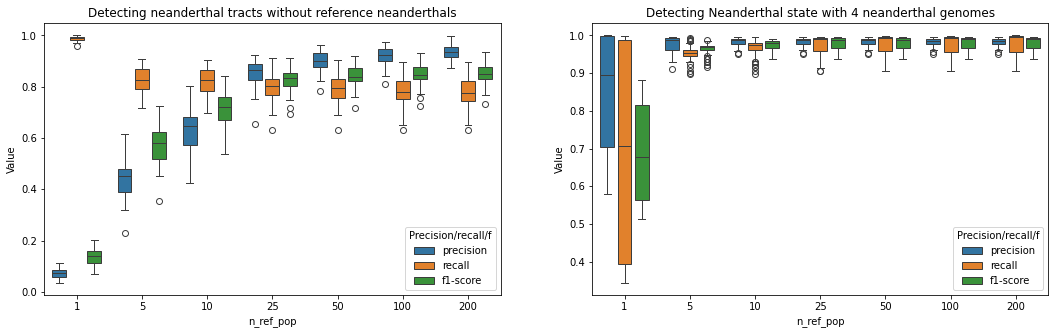

In [145]:
DF_ref_pop_1 = DF_ref_pop [DF_ref_pop ['State']==1& (DF_ref_pop['n_neand']==N_neanderthal)] 
DF_ref_pop_noND_1 = DF_ref_pop[(DF_ref_pop['State']==1) & (DF_ref_pop['n_neand']==0)] 


fig, axes = plt.subplots(1, 2, figsize=(18, 5))

seaborn.boxplot(ax=axes[0],data=DF_ref_pop_noND_1, x="n_ref_pop", y="Value", hue="Precision/recall/f", gap=.2).set_title('Detecting neanderthal tracts without reference neanderthals')
seaborn.boxplot(ax=axes[1],data=DF_ref_pop_1, x="n_ref_pop", y="Value", hue='Precision/recall/f', gap=.2).set_title('Detecting Neanderthal state with 4 neanderthal genomes')

plt.savefig('ref.pop.dep.png')

# n_ef_neand dependency

In [147]:
N_ND_mas=[3000, 6000, 10000]
cut=1000

nd_ancestries_mas = []
ts_mas=[]
for N_ND in N_ND_mas:
    
    
    N_e = np.array([N_ANC, N_ND, N_AMH, N_OOF, N_AF, N_EU])   
    TS =history_archaic(GEN_time, len_sequence, RR, MU, N_e, T,  n, rand_sd, n_neand,  T_NEAND_samples/GEN_time, n_eu)
    ts_mas.append(TS)
    nd_ancestries = []
    for idx in range(0,n_eu):       
        nd_ancestries.append( get_migrating_tracts_ind(TS, 'NEAND', idx, T[0]))        
    nd_ancestries_mas.append(nd_ancestries)  
    print('DOne')

DOne
DOne
DOne


In [149]:
L=1000
N_ref_pop = 100
N_neanderthal_mas = [0,2,4,6,8]

SEQ_nd_n_e = []
N_st_nd_n_e = []

N=2
for i_N_ND in range(len(N_ND_mas)):
    SEQ_nd = []
    N_st_nd = []
    for i_N_neanderthal in range(len(N_neanderthal_mas)):
        N_neanderthal = N_neanderthal_mas[i_N_neanderthal]
        sq, num = createSeqObs_several(ts_mas[i_N_ND], L,  n, N_ref_pop, N_neanderthal,  N_obs )
        SEQ_nd.append(sq)
        N_st_nd.append(num)
    SEQ_nd_n_e.append(SEQ_nd)
    N_st_nd_n_e.append(N_st_nd)
    print('Done')

Done
Done
Done


In [150]:
opt_params_values_nd_n_e = []
for i_N_ND in range(len(N_ND_mas)):
    N_ND = N_ND_mas[i_N_ND]
    opt_params_values_nd = []
    n_EM_steps = 10
    epsilon = 1e-16


    for i_N_neanderthal in range(len(N_neanderthal_mas)):
        N_neanderthal = N_neanderthal_mas[i_N_neanderthal]

        d = 2 * L * MU
        bnds = ((d*T[0], d*(T[0]+10000/GEN_time)), (d*T[1], d*(T[1]+100000/GEN_time)), 
                 (d*T[2], d*(T[2]+50000/GEN_time)))

        lmbd_00 = np.zeros(3)
        lmbd_00[0:3]= d * np.array([T[0]+400, T[1]+4000, T[2]+300])
        ind_num = 0

        opt_params_values_nd .append(opt_params(SEQ_nd_n_e[i_N_ND][i_N_neanderthal], 
                                                N_st_nd_n_e[i_N_ND][i_N_neanderthal], lmbd_00, 
                                                epsilon, N_neanderthal, bnds, ind_num, L, n_EM_steps))
    opt_params_values_nd_n_e.append( opt_params_values_nd)

In [152]:
DF_nd_n_e= pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'n_eu',
                                       'n_neand', 'L',  'n_ref_pop','n_e_nd'])
for i_N_ND in range(len(N_ND_mas)):
    N_ND = N_ND_mas[i_N_ND]
    for i_N_neanderthal in range(len(N_neanderthal_mas)):
        N_neanderthal = N_neanderthal_mas[i_N_neanderthal]
        DF_nd_n_e=pd.concat([createDataFrame(L, opt_params_values_nd_n_e[i_N_ND ][i_N_neanderthal], 
                                         N_st_nd_n_e[i_N_ND ][i_N_neanderthal], SEQ_nd_n_e[i_N_ND ][i_N_neanderthal], 
                                         N_neanderthal,
                                         N_ref_pop, N_obs,nd_ancestries_mas[i_N_ND]), DF_nd_n_e], ignore_index=True)      
    
    
DF_nd_n_e.to_csv('nd.n.e.dependency.csv', encoding='utf-8',index=False) 

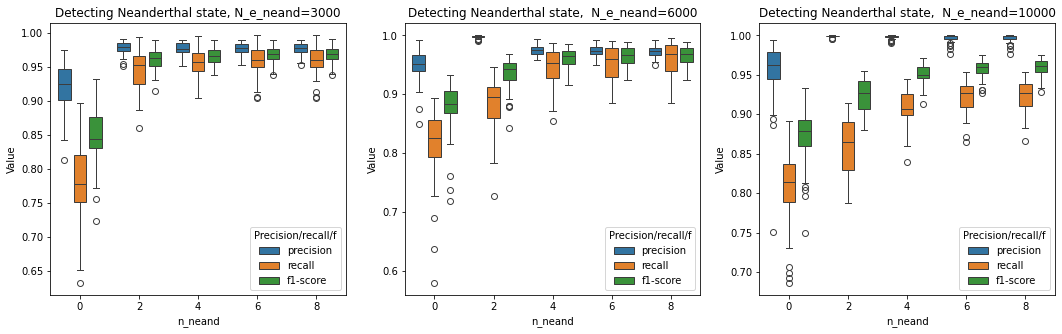

In [159]:


DF_nd_n_e_0 = DF_nd_n_e[(DF_nd_n_e['State']==1) & (DF_nd_n_e['n_e_nd']==N_ND_mas[0])] 
DF_nd_n_e_1 = DF_nd_n_e[(DF_nd_n_e['State']==1) & (DF_nd_n_e['n_e_nd']==N_ND_mas[1])] 
DF_nd_n_e_2 = DF_nd_n_e[(DF_nd_n_e['State']==1) & (DF_nd_n_e['n_e_nd']==N_ND_mas[2])] 

fig, axes = plt.subplots(1, 3, figsize=(18, 5))


seaborn.boxplot(ax=axes[0],data=DF_nd_n_e_0 , x="n_neand", y="Value", hue='Precision/recall/f', gap=.2).set_title('Detecting Neanderthal state, N_e_neand=3000')
seaborn.boxplot(ax=axes[1],data=DF_nd_n_e_1, x="n_neand", y="Value", hue='Precision/recall/f', gap=.2).set_title('Detecting Neanderthal state,  N_e_neand=6000')
seaborn.boxplot(ax=axes[2],data=DF_nd_n_e_2 , x="n_neand", y="Value", hue='Precision/recall/f', gap=.2).set_title('Detecting Neanderthal state,  N_e_neand=10000')
plt.savefig('ND.ne.dep.png')

In [ ]:
#/df,gldfg